<a href="https://colab.research.google.com/github/jamesakibble/MSc_thesis/blob/main/random_forest_regression_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Regression

## Importing the libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Importing the dataset, feature importance, collinearity

In [13]:
# Import cultivar specific dataset with EO, climate, and field measurement variables
dataset = pd.read_csv('escobal_518_use.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
X=dataset.drop(["yield", "seed_stage", "SAVI_ripe", "EVI_ripe", "NDVI_ripe", "EVI_repro", "NDVI_veg", "SAVI_veg", "SAVI_repro", "EVI_veg", "precip_airport", "temp_range", "avg_temp", "emer_har", "total_precip", "wet_day_freq", "precip_airport_meteo", "total_length", "max_temp", "hum", "min_temp", "sunlight"], axis=1)
print(X)

   emer_season  drought_days  NDVI_repro
0          JJA             4    0.845333
1          JJA             8    0.793112
2          SON             6    0.784710
3          SON             7    0.743301
4          MAM             4    0.821960
5          MAM             8    0.825233
6          MAM             6    0.778119
7          MAM             6    0.825286
8          SON             6    0.748486
9          DJF             6    0.748462
10         JJA            20    0.876790
11         MAM             8    0.844424
12         JJA            11    0.874029
13         MAM            22    0.866992


In [14]:
y = y.reshape(len(y),1)

In [15]:
#Encoding categorical variable for model inclusion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
pd.get_dummies(dataset, drop_first=True)
X = np.array(ct.fit_transform(X))

In [ ]:
#VIF test of multicollinearity - used on continuous data with variables >= removed from further modelling.
#X=dataset.drop(["Rice_yield", "SAVI_ripe", "EVI_ripe", "NDVI_ripe", "NDVI_veg", "SAVI_repro", "SAVI_veg", "NDVI_veg", "EVI_veg", "total_length", "Temp_range", "Max_temp", "hum", "Emer_to_har", "Min_temp", "Wet_day_freq", "Sun_light", "Total_precip_days"], axis=1)
#vif = np.array(X, dtype=int)
#vif
#vif["features"] = X.columns
#vif["vif_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#print(vif)

## Splitting the dataset into the Training set and Test set

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Training the Random Forest Regression model on the whole dataset

In [17]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(random_state = 42)

## Randomised CV

In [18]:
# Ramdomised Cross Validation of random forest algoritm to tune hyperparameters for optimum results
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 5000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 12, 14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [1, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 6, 8, 10],
 'min_samples_split': [2, 5, 10, 12, 14],
 'n_estimators': [1000, 1444, 1888, 2333, 2777, 3222, 3666, 4111, 4555, 5000]}


In [19]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
regressor = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
regressor_random = RandomizedSearchCV(estimator=regressor, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 5, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
regressor_random.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 22.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [20]:
regressor_random.best_params_

{'bootstrap': False,
 'max_depth': 1,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 3666}

In [21]:
y_pred = regressor_random.predict(X_test)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print(r2_score(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
mean_squared_error(y_test, y_pred)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

# regressor_random.fit(X_train, y_train)

0.8003840992277567
376.382306916534
484.1862184710697


In [23]:
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 7722.84428775  7640.666667  ]
 [ 9480.741112   10276.69903   ]
 [ 9480.741112    9229.72973   ]]


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


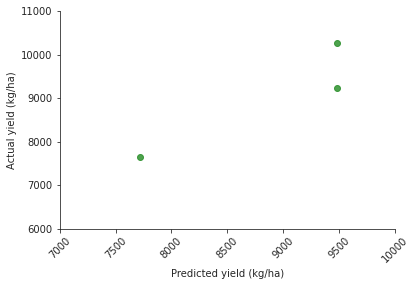

In [24]:
#scatter
import seaborn as sns
sns.set_style('ticks')
sns.regplot(y_pred, y_test, data=dataset, color="forestgreen", fit_reg=False)
plt.xlim(7000,10000)
plt.ylim(6000,11000)
plt.xticks(rotation=45)
plt.xlabel("Predicted yield (kg/ha)")
plt.ylabel("Actual yield (kg/ha)")
sns.despine()
plt.savefig('escobal_518_scatter.png')

In [25]:
# feature importance
print(regressor_random.best_params_)

{'n_estimators': 3666, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 1, 'bootstrap': False}


## Gridsearch CV

In [30]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [1, 2, 4, 6, 8, 10, 12, 15],
    'max_features': [1, 2, 3],
    'min_samples_leaf': [2, 4, 8, 12, 16, 20, 30, 40, 50],
    'min_samples_split': [0.5, 1, 5, 10, 20],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

# Create a base model
regressor = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = regressor, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, return_train_score=True)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train);

In [ ]:
grid_search.best_params_

In [ ]:
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

In [ ]:
y_pred_grid = grid_search.predict(X_test)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print(r2_score(y_test, y_pred_grid))
print(mean_absolute_error(y_test, y_pred_grid))
mean_squared_error(y_test, y_pred_grid)
print(np.sqrt(mean_squared_error(y_test, y_pred_grid)))